<a href="https://colab.research.google.com/github/dhritiburugupalli/regime-adaptability/blob/main/regime_adaptability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Saves files to Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Data/Figure/Table download
from google.colab import files
files.download(feature_path) # change path

In [1]:
# Organizes the files and creates project folders
import os

BASE_DIR = "/content/drive/MyDrive/ml-regime-adaptability"
folders = [
    "data",
    "results/figures",
    "results/tables",
    "notebooks"
]

for f in folders:
    os.makedirs(os.path.join(BASE_DIR, f), exist_ok=True)

print("Folders created under:", BASE_DIR)

Folders created under: /content/drive/MyDrive/ml-regime-adaptability


In [82]:
# Downloads yahoo finance data, pandas, numpy, skikit-learn, and matplotlib
!pip install yfinance pandas numpy scikit-learn matplotlib
!pip -q install tensorflow

In [84]:
# Imports libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler


In [4]:
# Download SPY Data
ticker = "SPY"
start_date = "2010-01-01"

df = yf.download(ticker, start=start_date)

# flatten MultiIndex columns from yfinance
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print("Columns:", df.columns)

df.head()

/tmp/ipython-input-2870951736.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date)
[*********************100%***********************]  1 of 1 completed

Columns: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,85.028000,85.073014,83.662510,84.307742,118944600
2010-01-05,85.253021,85.290537,84.667813,84.975426,111579900
2010-01-06,85.313072,85.523147,85.102998,85.170519,116074400
2010-01-07,85.673172,85.778209,84.915399,85.155485,131091100
2010-01-08,85.958275,85.995791,85.275533,85.448092,126402800


In [5]:
# Dataset check
print(df.shape)
print(df.index.min(), "to", df.index.max())
df.isna().sum()

(4055, 5)
2010-01-04 00:00:00 to 2026-02-17 00:00:00


,0
Price,
Close,0
High,0
Low,0
Open,0
Volume,0


In [6]:
# Daily returns
df["Return"] = df["Close"].pct_change()
df[["Close", "Return"]].head()

Price,Close,Return
Date,,
2010-01-04,85.028000,NaN
2010-01-05,85.253021,0.002646
2010-01-06,85.313072,0.000704
2010-01-07,85.673172,0.004221
2010-01-08,85.958275,0.003328


In [7]:
# 20 daily volatility
# Demonstrates the regime through the "chaotic" of market
df["Volatility_20"] = df["Return"].rolling(window=20).std()
df[["Return", "Volatility_20"]].head(25)

Price,Return,Volatility_20
Date,,
2010-01-04,NaN,NaN
2010-01-05,0.002646,NaN
2010-01-06,0.000704,NaN
2010-01-07,0.004221,NaN
2010-01-08,0.003328,NaN
2010-01-11,0.001397,NaN
2010-01-12,-0.009326,NaN
2010-01-13,0.008446,NaN
2010-01-14,0.002705,NaN


In [8]:
# Clean up the data by cleaning missing rows
df = df.dropna()
print("After dropna:", df.shape)

After dropna: (4035, 7)


In [9]:
# Regime distinguishing
low = df["Volatility_20"].quantile(0.33)
high = df["Volatility_20"].quantile(0.66)

low, high


(np.float64(0.0063448977734655385), np.float64(0.009518071621703159))

In [10]:
# regime labeling
def label_regime(vol):
    if vol <= low:
        return "Low"
    elif vol <= high:
        return "Medium"
    else:
        return "High"

df["Regime"] = df["Volatility_20"].apply(label_regime)

df["Regime"].value_counts()

,count
Regime,
High,1372
Low,1332
Medium,1331


In [11]:
# Detecting regime shifts
df["Shift"] = df["Regime"] != df["Regime"].shift(1)

shift_days = df[df["Shift"]]

print("Number of shift days:", len(shift_days))
shift_days.head()


Number of shift days: 292


Price,Close,High,Low,Open,Volume,Return,Volatility_20,Regime,Shift
Date,,,,,,,,,
2010-02-02,82.814651,82.972207,81.689249,81.974354,216327900,0.012103,0.010585,High,True
2010-03-05,85.718201,85.785722,84.855391,85.057966,176118800,0.014293,0.007058,Medium,True
2010-03-10,86.258400,86.490981,85.838251,85.913277,186088800,0.004456,0.006337,Low,True
2010-04-27,89.257881,91.412480,89.084606,90.892667,355853300,-0.023651,0.008339,Medium,True
2010-04-30,89.506500,91.163892,89.483900,91.065952,270000900,-0.016962,0.009632,High,True


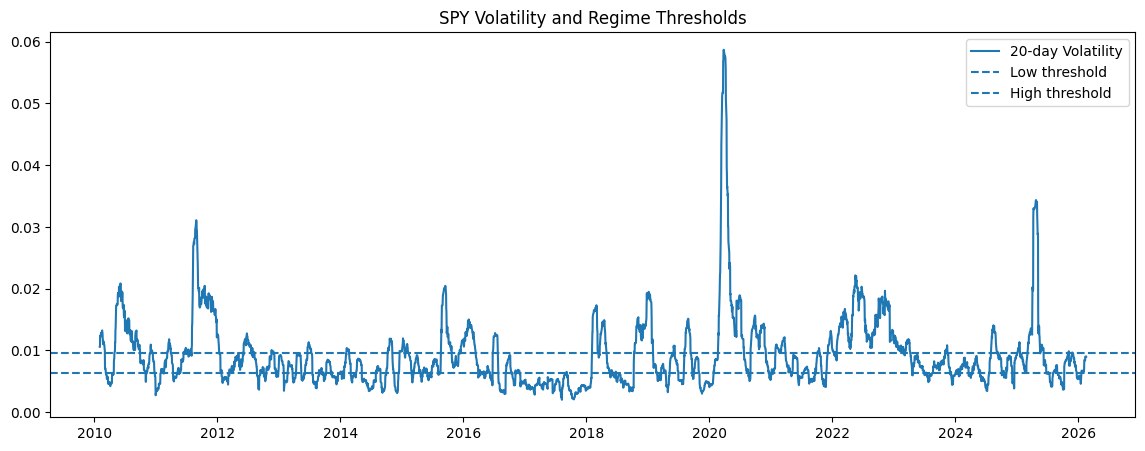

Saved to: /content/drive/MyDrive/ml-regime-adaptability/results/figures/day1_volatility_thresholds.png
Saved data to: /content/drive/MyDrive/ml-regime-adaptability/data/spy_with_regimes.csv


In [12]:
# plotting the 20 day volatility and low and high thresholds
plt.figure(figsize=(14,5))
plt.plot(df.index, df["Volatility_20"], label="20-day Volatility")

# plots the thresholds
plt.axhline(low, linestyle="--", label="Low threshold")
plt.axhline(high, linestyle="--", label="High threshold")

# sets up the graph and displaus it
plt.title("SPY Volatility and Regime Thresholds")
plt.legend()
plt.show()

# saves the graph/data
fig_path = f"{BASE_DIR}/results/figures/day1_volatility_thresholds.png"
plt.savefig(fig_path, dpi=200)
plt.close()
print("Saved to:", fig_path)

# save the processed dataset
csv_path = f"{BASE_DIR}/data/spy_with_regimes.csv"
df.to_csv(csv_path)
print("Saved data to:", csv_path)

In [13]:
# target: next day direction
# astype converts to binary; shift moves values up so
# todays row gets tomorrows return
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

# positive -> true -> 1
# negative -> false -> 0
df[["Return", "Target"]].head(10)

Price,Return,Target
Date,,
2010-02-02,0.012103,0
2010-02-03,-0.004983,0
2010-02-04,-0.030866,1
2010-02-05,0.002067,0
2010-02-08,-0.007219,1
2010-02-09,0.012560,0
2010-02-10,-0.001959,1
2010-02-11,0.010466,0
2010-02-12,-0.000832,1


In [14]:
# number of positive and negative targets
df["Target"].value_counts()

,count
Target,
1,2233
0,1802


In [15]:
# features - the signals models use to predict
# 1: changing averages
df["MA_10"] = df["Close"].rolling(10).mean() # over 10 days
df["MA_50"] = df["Close"].rolling(50).mean() # over 50 days

# 2: how much price changed over 10 days (pos = upward trend)
df["Momentum_10"] = df["Close"] - df["Close"].shift(10)

# 3: volatility (short term over 5 days)
df["Volatility_5"] = df["Return"].rolling(5).std()

# 4: volume - trading activity spikes
df["Volume_Change"] = df["Volume"].pct_change()

In [16]:
# clean data (removing NaN values)
# Some rows have missing values as features need past or
# future data
df_clean = df.dropna()
print("Original:", df.shape)
print("Clean:", df_clean.shape)

# Check (checked eworks)
df_clean[["Close", "Return", "Target"]].head(5)

Original: (4035, 15)
Clean: (3986, 15)


Price,Close,Return,Target
Date,,,
2010-04-14,91.299507,0.011350,1
2010-04-15,91.374847,0.000825,0
2010-04-16,89.920876,-0.015912,1
2010-04-19,90.259857,0.003770,1
2010-04-20,91.065948,0.008931,0


In [17]:
# define feature matrix (X: input; y: output)
feature_cols = [
    "Return",
    "Volatility_20",
    "Volatility_5",
    "MA_10",
    "MA_50",
    "Momentum_10",
    "Volume_Change"
]

X = df_clean[feature_cols]
y = df_clean["Target"]

# save feature dataset
print(X.shape, y.shape)

feature_path = f"{BASE_DIR}/data/spy_features_ready.csv"
df_clean.to_csv(feature_path)

print("Saved dataset to:", feature_path)

(3986, 7) (3986,)
Saved dataset to: /content/drive/MyDrive/ml-regime-adaptability/data/spy_features_ready.csv


In [21]:
# Import model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Training window (in days)
window = 252

In [20]:
# walk forward loop
def walk_forward_model(model, X, y, window):
    predictions = []
    actuals = []
    dates = []

    for i in range(window, len(X)):
        # Training data (past window)
        X_train = X.iloc[i-window:i]
        y_train = y.iloc[i-window:i]

        # Test data (today)
        X_test = X.iloc[i:i+1]
        y_test = y.iloc[i]

        # Train & predict
        model.fit(X_train, y_train)
        pred = model.predict(X_test)[0]

        # Store results
        predictions.append(pred)
        actuals.append(y_test)
        dates.append(X.index[i])

    results = pd.DataFrame({
        "Date": dates,
        "Prediction": predictions,
        "Actual": actuals
    }).set_index("Date")

    return results


In [43]:
log_model = LogisticRegression(max_iter=500, solver="liblinear")

results_log = walk_forward_model(log_model, X, y, window)

results_log.head()

,Prediction,Actual
Date,,
2011-04-12,1,0
2011-04-13,1,1
2011-04-14,1,1
2011-04-15,1,0
2011-04-18,1,1


In [47]:
rf_model = RandomForestClassifier(
    n_estimators=25,
    max_depth=5,
    random_state=42
)

results_rf = walk_forward_model(rf_model, X, y, window)

results_rf.head()

,Prediction,Actual
Date,,
2011-04-12,0,0
2011-04-13,0,1
2011-04-14,1,1
2011-04-15,1,0
2011-04-18,1,1


In [48]:
# Logistic Regression Accuracy
acc_log = (results_log["Prediction"] == results_log["Actual"]).mean()
print("Logistic Regression Accuracy:", acc_log)

# Save Logistic Regression Prediction
log_path = f"{BASE_DIR}/results/tables/day4_logistic_predictions.csv"
results_log.to_csv(log_path)
print("Saved logistic predictions:", log_path)

# Random Forest Accuracy
acc_rf = (results_rf["Prediction"] == results_rf["Actual"]).mean()
print("Random Forest Accuracy:", acc_rf)

# Save Random Forest Prediction
rf_path = f"{BASE_DIR}/results/tables/day4_rf_predictions.csv"
results_rf.to_csv(rf_path)

print("Saved RF predictions:", rf_path)


Logistic Regression Accuracy: 0.5324049276914836
Saved logistic predictions: /content/drive/MyDrive/ml-regime-adaptability/results/tables/day4_logistic_predictions.csv
Random Forest Accuracy: 0.4973219068023567
Saved RF predictions: /content/drive/MyDrive/ml-regime-adaptability/results/tables/day4_rf_predictions.csv


In [76]:
# Baseline Comparison Table
baseline_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [acc_log, acc_rf]
})
baseline_table

# Save
baseline_path = f"{BASE_DIR}/results/tables/day4_baseline_accuracy.csv"
baseline_table.to_csv(baseline_path, index=False)

print("Saved baseline table:", baseline_path)

Saved baseline table: /content/drive/MyDrive/ml-regime-adaptability/results/tables/day4_baseline_accuracy.csv


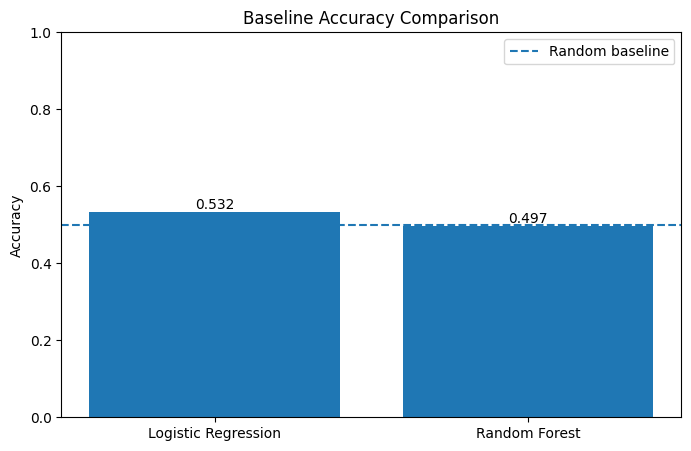

Saved figure to: /content/drive/MyDrive/ml-regime-adaptability/results/figures/day4_baseline_comparison.png


In [78]:
plt.figure(figsize=(8,5))
bars = plt.bar(baseline_table["Model"],
               baseline_table["Accuracy"])
plt.axhline(0.5, linestyle="--", label="Random baseline")
plt.title("Baseline Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f"{height:.3f}",
             ha="center",
             va="bottom")

plt.legend()
plt.show()

# Save
baseline_fig_path = f"{BASE_DIR}/results/figures/day4_baseline_comparison.png"
plt.figure(figsize=(8,5))
bars = plt.bar(baseline_table["Model"],
               baseline_table["Accuracy"])
plt.axhline(0.5, linestyle="--")
plt.title("Baseline Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height,
             f"{height:.3f}",
             ha="center",
             va="bottom")

plt.savefig(baseline_fig_path, dpi=200)
plt.close()
print("Saved figure to:", baseline_fig_path)


In [81]:
# check
print(4005-252)
print(len(results_log))

# checks to make sure model predictions vary & data moves forward
results_log["Prediction"].value_counts()
results_log.head(10)

3753
3734


,Prediction,Actual,Correct,Rolling_Accuracy
Date,,,,
2011-04-12,1,0,0,NaN
2011-04-13,1,1,1,NaN
2011-04-14,1,1,1,NaN
2011-04-15,1,0,0,NaN
2011-04-18,1,1,1,NaN
2011-04-19,1,1,1,NaN
2011-04-20,1,1,1,NaN
2011-04-21,1,0,0,NaN
2011-04-25,1,1,1,NaN


In [80]:
# check
print(4005-252)
print(len(results_rf))

# checks to make sure model predictions vary & data moves forward
results_rf["Prediction"].value_counts()
results_rf.head(10)

3753
3734


,Prediction,Actual,Correct,Rolling_Accuracy
Date,,,,
2011-04-12,0,0,1,NaN
2011-04-13,0,1,0,NaN
2011-04-14,1,1,1,NaN
2011-04-15,1,0,0,NaN
2011-04-18,1,1,1,NaN
2011-04-19,1,1,1,NaN
2011-04-20,0,1,0,NaN
2011-04-21,1,0,0,NaN
2011-04-25,1,1,1,NaN


In [79]:
# Rolling accuracy (overtime) for linear regression
results_log["Correct"] = (results_log["Prediction"] == results_log["Actual"]).astype(int)
results_log["Rolling_Accuracy"] = results_log["Correct"].rolling(50).mean()

# Rolling accuracy (overtime) for random forest
results_rf["Correct"] = (results_rf["Prediction"] == results_rf["Actual"]).astype(int)
results_rf["Rolling_Accuracy"] = results_rf["Correct"].rolling(50).mean()

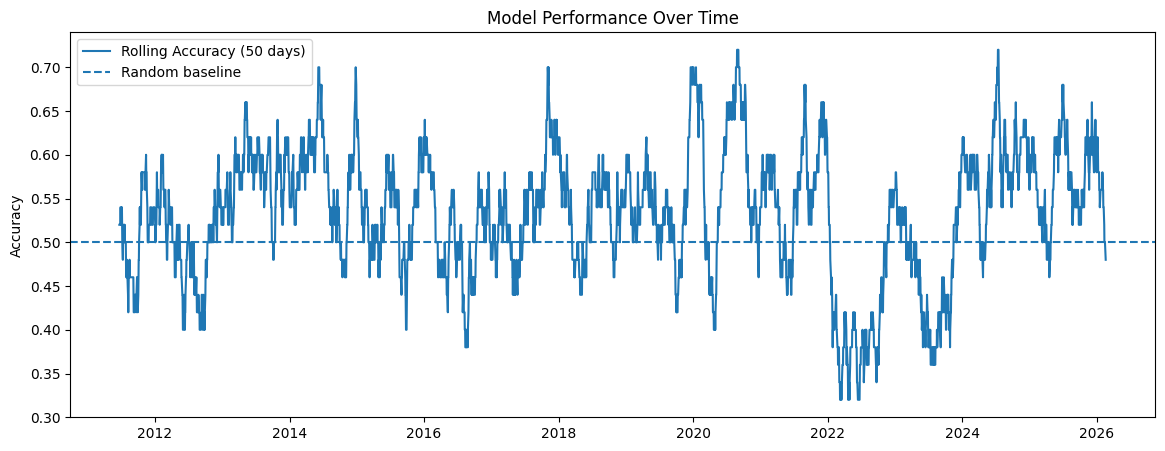

Saved predictions to: /content/drive/MyDrive/ml-regime-adaptability/results/tables/day3_log_predictions.csv
Saved figure to: /content/drive/MyDrive/ml-regime-adaptability/results/figures/day3_log_accuracy_plot.png


In [72]:
# performance overtime (plotted)
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(results_log.index, results_log["Rolling_Accuracy"],
         label="Rolling Accuracy (50 days)")

plt.axhline(0.5, linestyle="--", label="Random baseline")
plt.title("Model Performance Over Time")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# saves predictions
results_log_path = f"{BASE_DIR}/results/tables/day3_log_predictions.csv"
results_log.to_csv(results_log_path)
print("Saved predictions to:", results_log_path)

# saves figure
log_fig_path = f"{BASE_DIR}/results/figures/day3_log_accuracy_plot.png"
plt.figure(figsize=(14,5))
plt.plot(results_log.index, results_log["Rolling_Accuracy"])
plt.axhline(0.5, linestyle="--")
plt.savefig(log_fig_path, dpi=200)
plt.close()
print("Saved figure to:", log_fig_path)



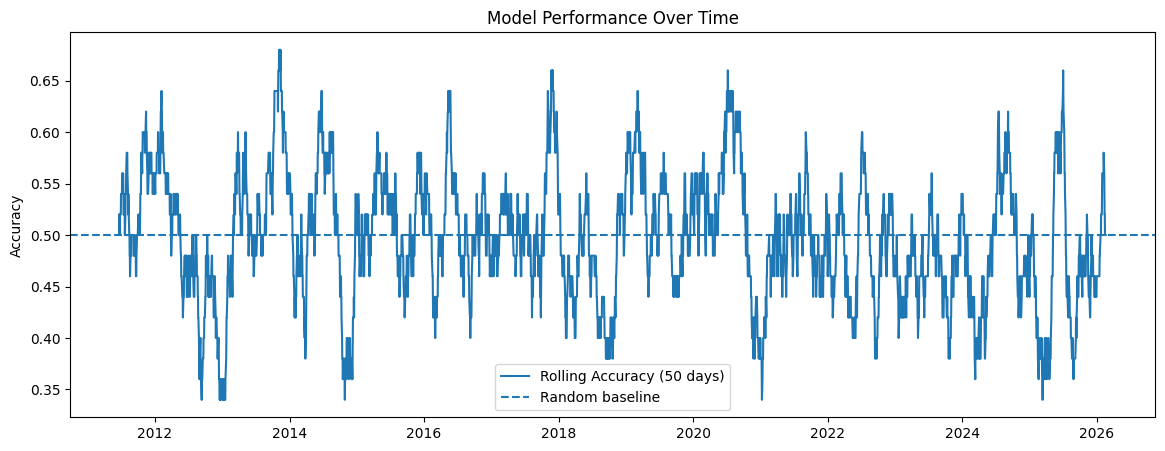

Saved predictions to: /content/drive/MyDrive/ml-regime-adaptability/results/tables/day4_rf_predictions.csv
Saved RF figure to: /content/drive/MyDrive/ml-regime-adaptability/results/figures/day4_rf_accuracy_plot.png


In [75]:
# performance overtime (plotted)
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(results_rf.index, results_rf["Rolling_Accuracy"],
         label="Rolling Accuracy (50 days)")

plt.axhline(0.5, linestyle="--", label="Random baseline")
plt.title("Model Performance Over Time")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# saves predictions
results_rf_path = f"{BASE_DIR}/results/tables/day4_rf_predictions.csv"
results_rf.to_csv(results_rf_path)
print("Saved predictions to:", results_rf_path)

# saves figure
rf_fig_path = f"{BASE_DIR}/results/figures/day4_rf_accuracy_plot.png"
plt.figure(figsize=(14,5))
plt.plot(results_rf.index,
         results_rf["Rolling_Accuracy"],
         label="RF Rolling Accuracy")
plt.axhline(0.5, linestyle="--", label="Random baseline")

plt.title("Random Forest Performance Over Time")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig(rf_fig_path, dpi=200)
plt.close()

print("Saved RF figure to:", rf_fig_path)

In [87]:
# LSTM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
seq_len = 20 # sequence length

def create_sequences(X, y, seq_len):

    X_seq = []
    y_seq = []

    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y.iloc[i])

    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, seq_len)
print(X_seq.shape, y_seq.shape)


(3966, 20, 7) (3966,)


In [93]:
# walk forward alg implement
def walk_forward_lstm(X_seq, y_seq, dates, window):

    predictions = []
    actuals = []
    pred_dates = []

    for i in range(window, len(X_seq)):

        X_train = X_seq[i-window:i]
        y_train = y_seq[i-window:i]

        X_test = X_seq[i:i+1]
        y_test = y_seq[i]

        # Build model fresh each iteration
        from tensorflow.keras.layers import Input

        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(8),
            Dense(1, activation="sigmoid")
        ])

        model.compile(
            optimizer="adam",
            loss="binary_crossentropy"
        )

        model.fit(
            X_train,
            y_train,
            epochs=1,
            batch_size=32,
            verbose=0
        )

        pred_prob = model.predict(X_test, verbose=0)[0][0]
        pred = int(pred_prob > 0.5)

        predictions.append(pred)
        actuals.append(y_test)
        pred_dates.append(dates[i])

    results = pd.DataFrame({
        "Date": pred_dates,
        "Prediction": predictions,
        "Actual": actuals
    }).set_index("Date")

    return results


In [94]:
dates_seq = X.index[seq_len:]

results_lstm = walk_forward_lstm(
    X_seq,
    y_seq,
    dates_seq,
    window=63
)

results_lstm.head()

# check accuracy
acc_lstm = (results_lstm["Prediction"] == results_lstm["Actual"]).mean()
print("LSTM Accuracy:", acc_lstm)

# save
lstm_path = f"{BASE_DIR}/results/tables/day4_lstm_predictions.csv"
results_lstm.to_csv(lstm_path)
print("Saved LSTM predictions:", lstm_path)


KeyboardInterrupt: 